In [1]:
!pip install matplotlib seaborn scikit-learn pandas xgboost flask joblib

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
     --------- --------------------------- 30.7/115.4 kB 660.6 kB/s eta 0:00:01
     ---------------------- -------------- 71.7/115.4 kB 975.2 kB/s eta 0:00:01
     -------------------------------------- 115.4/115.4 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.6 MB/s eta 0:00:00
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB 8.3 MB/s eta 0:00:01
   - -------------------------------------- 0.4/8.1 MB 5.7 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuration for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


In [3]:
# Load the dataset
# Make sure the csv file is in the 'dataset' folder or update the path
df = pd.read_csv('dataset/cardio_train.csv', sep=';')

# Display first 5 rows
display(df.head())

# Check data types and missing values
print("\nData Info:")
print(df.info())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None


In [4]:
print(f"Original Shape: {df.shape}")

# 1. Convert Age from days to years
df['age'] = (df['age'] / 365).round().astype('int')

# 2. Drop 'id' column (irrelevant for prediction)
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# 3. Filter Outliers (Crucial step for this dataset)
# Remove impossible blood pressure values
df = df[(df['ap_hi'] > 50) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 30) & (df['ap_lo'] < 160)]

# Systolic (ap_hi) must be greater than Diastolic (ap_lo)
df = df[df['ap_hi'] >= df['ap_lo']]

# Remove extreme height and weight outliers
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

print(f"Shape after Cleaning: {df.shape}")

Original Shape: (70000, 13)
Shape after Cleaning: (68559, 12)


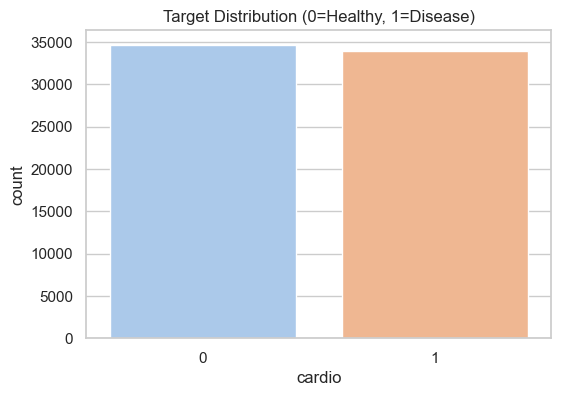

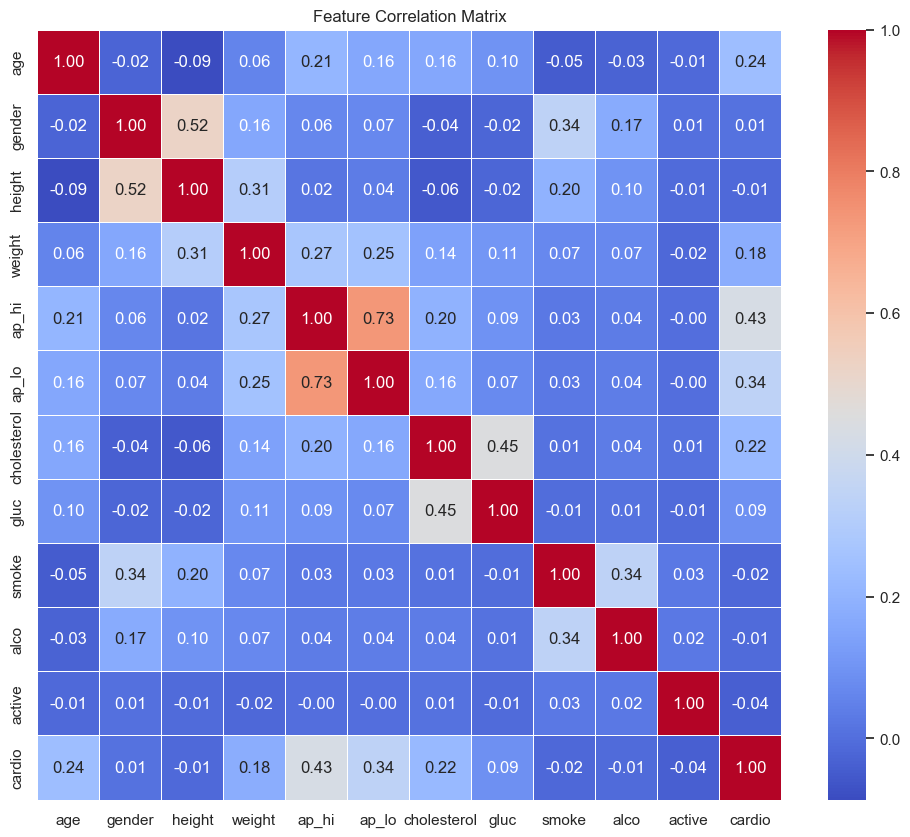

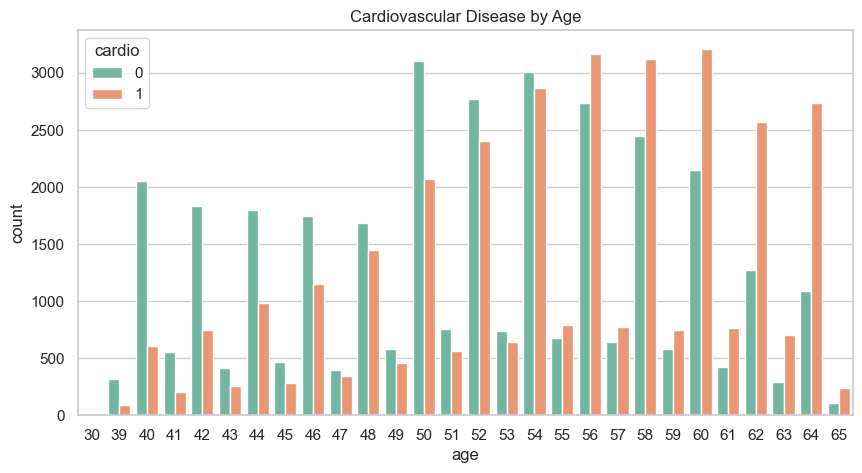

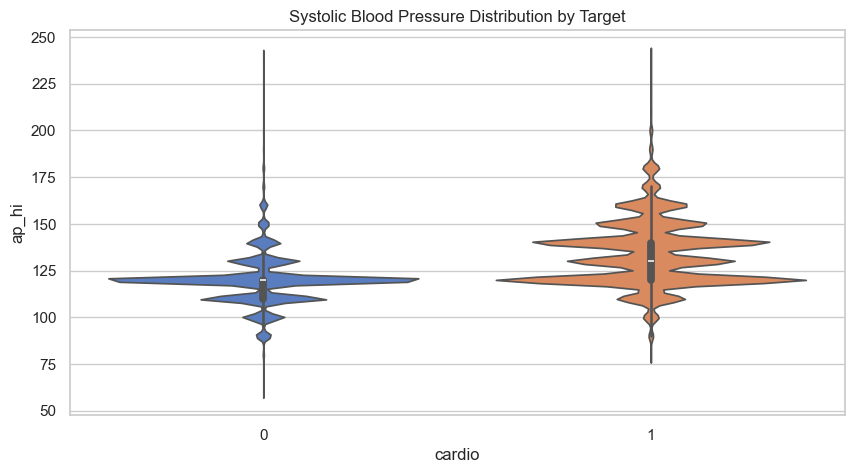

In [5]:
# Plot 1: Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df, palette='pastel')
plt.title('Target Distribution (0=Healthy, 1=Disease)')
plt.show()

# Plot 2: Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Plot 3: Age vs Disease
plt.figure(figsize=(10, 5))
sns.countplot(x='age', hue='cardio', data=df, palette='Set2')
plt.title('Cardiovascular Disease by Age')
plt.show()

# Plot 4: Violin Plot for Blood Pressure (Split by Disease)
plt.figure(figsize=(10, 5))
sns.violinplot(x='cardio', y='ap_hi', data=df, palette='muted')
plt.title('Systolic Blood Pressure Distribution by Target')
plt.show()

In [6]:
# Split features and target
X = df.drop('cardio', axis=1)
y = df['cardio']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Normalization) - Essential for Linear Models, helpful for others
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Split and Scaled Successfully.")

Data Split and Scaled Successfully.


In [7]:
# --- 1. Logistic Regression ---
print("Training Logistic Regression...")
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

# --- 2. Random Forest ---
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) # Tree models work well with unscaled data too
rf_pred = rf.predict(X_test)

# --- 3. XGBoost ---
print("Training XGBoost...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("\nAll models trained.")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...

All models trained.


Logistic Regression Accuracy: 0.7275
Random Forest Accuracy:       0.7060
XGBoost Accuracy:             0.7345

--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      6867
           1       0.71      0.70      0.70      6845

    accuracy                           0.71     13712
   macro avg       0.71      0.71      0.71     13712
weighted avg       0.71      0.71      0.71     13712



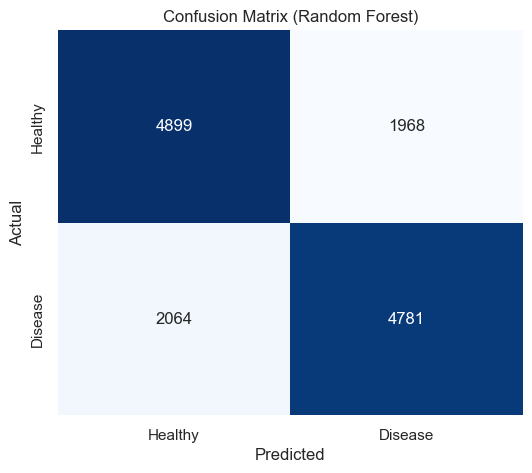

In [8]:
# Accuracy Scores
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Random Forest Accuracy:       {accuracy_score(y_test, rf_pred):.4f}")
print(f"XGBoost Accuracy:             {accuracy_score(y_test, xgb_pred):.4f}")

# Classification Report for Random Forest (our chosen model)
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, rf_pred))

# Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Healthy', 'Disease'])
plt.yticks([0.5, 1.5], ['Healthy', 'Disease'])
plt.show()

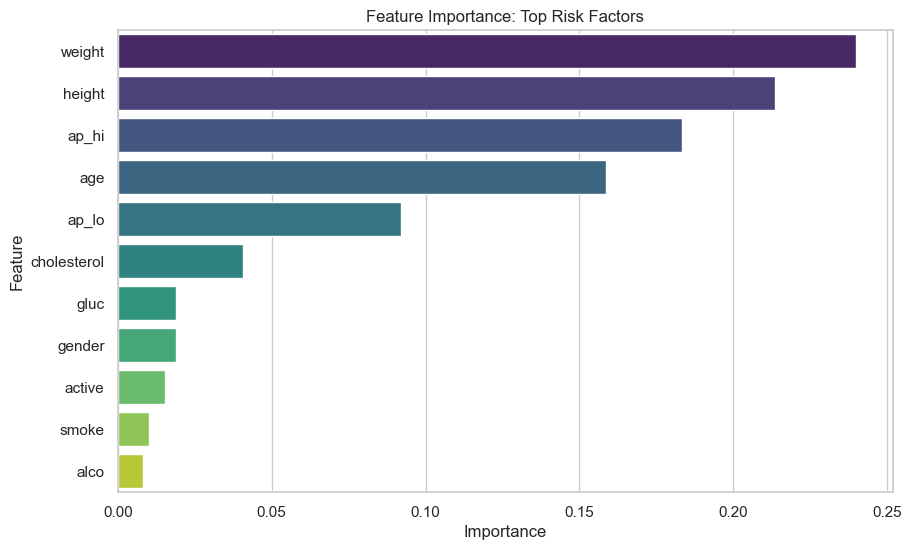

Top 3 Risk Factors:
  Feature  Importance
3  weight    0.239925
2  height    0.213751
4   ap_hi    0.183266


In [9]:
# Extract importances
importances = rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance: Top Risk Factors')
plt.show()

print("Top 3 Risk Factors:")
print(feat_imp_df.head(3))

In [10]:
import os

# Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the Random Forest model (Best balance of speed/accuracy)
joblib.dump(rf, 'models/model_rf.pkl')

print("Model saved successfully to 'models/model_rf.pkl'")
print("You can now run app.py!")

Model saved successfully to 'models/model_rf.pkl'
You can now run app.py!
